# Summary and plan of attack:

Different regressionmodels will be tested to see if the value and variance of the choosed target variable 'qc_salzrckhalt' can be predicted. To appy regression models the dataset needs to be reduced in feature size.

Firstly the dataset will be reduced in feature size, this means that unneccasarry features will be removed. Comments will explain why a feature is regarded as not important. Secondly new features will be created. Comments will explain why this feature has been created.

##### Required moduls: 

- statsmodels
- pandas
- numpy





## Dataset will be reduced in feature size

In [1]:
# Import needed libaries
import pandas as pd
import os
import numpy as np


# read in dataset and remove previouly set multiindex
df = pd.read_csv("process_data_df10.csv", header=[0,1], na_values=['nan'],
sep=',',low_memory=False)

# delet column without any information 
df.drop(['Unnamed: 0_level_0'],axis=1, inplace = True)
df = df.droplevel(level=0,axis=1)

# drop na and duplicates from qc_serien number since following assumption is made:
# every qc has one serial number, if it occurs twice the sample has been tested twice, since there are
# less than 1000 duplicates (less than 0.5 % of whole dataset) to keep them
df = df.dropna(subset = ['qc_serien_nummer']).drop_duplicates(subset = ['qc_serien_nummer'])#.set_index('qc_serien_nummer')
df

/home/elron/anaconda3/envs/da/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


,ps,ps_datum,ps_beschichtete_rollenlange_m,ps_c_losung_wt_%,ps_gap_micro_m,ps_dicke_as_micro_m,ps_dicke_1,ps_dicke_2,ps_dicke_3,ps_dicke_4,...,p_product_size,p_effective_area_per_leaf_m2,p_effective_pressure_bar,qc_flux_l/m2/h,qc_a-value_l/m2/h/bar,qc_b-value_m/s_10-6,qc_flux_m3/m2/day,sum_of_scrap,roll_position,p_Product_type_group
0,cb031d4b18ff,2018-05-13,4487.0,31.0,250.0,136.0,136.0,134.0,134.0,135.0,...,8,1.4646,8.71,40.286235,4.625285,3.678446,0.966870,0.0,58.181818,Low Energy
1,cb031d4b18ff,2018-05-13,4487.0,31.0,250.0,136.0,136.0,134.0,134.0,135.0,...,8,1.4646,8.71,40.252401,4.621401,3.165247,0.966058,0.0,116.363636,Low Energy
2,cb031d4b18ff,2018-05-13,4487.0,31.0,250.0,136.0,136.0,134.0,134.0,135.0,...,8,1.4646,8.71,39.718186,4.560067,3.170593,0.953236,0.0,174.545455,Low Energy
3,cb031d4b18ff,2018-05-13,4487.0,31.0,250.0,136.0,136.0,134.0,134.0,135.0,...,8,1.4646,8.71,39.441426,4.528292,2.855092,0.946594,0.0,232.727273,Low Energy
4,cb031d4b18ff,2018-05-13,4487.0,31.0,250.0,136.0,136.0,134.0,134.0,135.0,...,8,1.4646,8.71,39.731817,4.561632,2.810373,0.953564,0.0,290.909091,Low Energy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118682,3fa606fdd9e8,2018-05-14,2202.0,31.0,250.0,137.0,135.0,133.0,133.0,132.0,...,8,1.4646,8.71,36.149091,4.150297,3.606951,0.867578,0.0,0.000000,Low Energy
118683,3fa606fdd9e8,2018-05-14,2202.0,31.0,250.0,137.0,135.0,133.0,133.0,132.0,...,8,1.4646,8.71,35.645870,4.092522,3.266436,0.855501,0.0,0.000000,Low Energy
118684,3fa606fdd9e8,2018-05-14,2202.0,31.0,250.0,137.0,135.0,133.0,133.0,132.0,...,8,1.4646,8.71,34.888194,4.005533,3.464832,0.837317,0.0,0.000000,Low Energy
118685,3fa606fdd9e8,2018-05-14,2202.0,31.0,250.0,137.0,135.0,133.0,133.0,132.0,...,8,1.4646,8.71,37.721778,4.330859,3.255691,0.905323,0.0,0.000000,Low Energy


#### 2. remove all richtwert and ref columns into seperate dataframe

- Richtwert and Ref are not measured during the different processes, therefore they can be removed to a seperate dataframe

In [2]:
df1 = df.copy()
result = pd.concat([df1.filter(regex = '_ref'), df1.filter(regex = '_richtwert_')], axis = 1, sort = False)
result1 = result.loc[:,~result.columns.duplicated()]
#result1 = result1.join(identdf)
#result1.to_pickle('Richtwert_ref_variables_dataset.pkl')
df1.drop(result1, axis = 1, inplace = True)

#### 3. make mean column and drop the columns the mean is made from
- Creation of mean columns as features and dropping of multiple measurement columns. No outliers are removed. 

In [3]:
df2 = df1.copy()

# Multiple Measurment columns
meanList = ['pa_cm-pda','pa_chlorkonzentration','pa_air-knife_vor_amin_bad','airknife_vor_amin_trockner',
            'pa_amin-trockner_feuchtigkeit_danfugt_bs','pa_amin-trockner_feuchtigkeit_danfugt_as','pa_amin-trockner_feuchtigkeit_cofely',
            'ps_dicke','ps_bad_temperatur','ps_auftragswerk_feuchtigkeit','sc_d_links_werte','sc_d_rechts_werte']


# Funktion to drop multiple measurment values
def MeanColumnCreate(meanList, df):
  for i in meanList:
      filterdf = df.filter(regex = i)
      name = i+"_mean"
      df[name] = filterdf.iloc[:].mean(axis = 1)
      df.drop(filterdf, axis = 1, inplace = True)

In [4]:
MeanColumnCreate(meanList, df2)
df2.to_pickle('process_data_mean_columns_added')

#### 4. remove all median columns 
- The median can be created on demand if needed, therefore the median columns are removed

In [5]:
df3 = df2.copy()
df3.drop(df3.filter(regex = 'median'), axis = 1, inplace = True)

#### 5. remove all datetimes columns 
- The hypothesis testing, see other notebook does not depend on the date, therefore this columns are dropped

In [6]:
df4 = df3.copy()
dfdate = df4.select_dtypes(include = ['datetime64']).join(df4[['reaction_end','reaction_start']])
df4.drop(dfdate, axis = 1, inplace = True)

#### 6. remove all columns with the keyword datum

In [7]:
df5 = df4.copy()
df5.drop(df5.filter(regex = 'datum'), axis = 1, inplace = True)

#### 7. drop of certain columns, for detail see comments

In [8]:
dropList = ['qc_maximalersalzrueckhalt','qc_breite','sc_d_links_anz_max','sc_d_rechts_anz_min',
            'sc_d_rechts_anz_max','qc_barcode_leak_test_values', 'ps','pa_coating','nr','pa_mpda_lsg','pa_chlorlsg','pa_sbs_lsg',
            'pa_alkalilsg','p_product_size','p_effective_area_per_leaf_m2','p_product_type', 'pa_beschichtete_rollenlange_m','pp_actual_product',
           'pp_actual_product_short_name','pp_plan_ausbeute_elemente', 'pp_plan_product', 'pp_product_short_name',
           'qc_p_position','roll_position','winding_product_short_name','winding_product_type','assembled_in_elements_m', 'winding_product_line',
           'qc_mstaerke','qc_nachkommadurchfluss','qc_temperaturc', 'pa_tmc_gehalt_%']

df6 = df5.copy()
for i in dropList:
    df6.drop(i, axis = 1, inplace = True)
# qc_maximalersalzruckhalt : just two values 0 and 99.99 
# qc_breite : just two values 985 and 0
# sc_d_links_anz_max : because has 118639 zero values (0.04 % are not zero)
# sc_d_rechts_anz_min : has 118674 (> 99.9%) zeros
# sc_d_rechts_anz_max  : has 118528 (99.9%) zeros
# qc_barcode_leak_test : categorical variable not fully understood
# ps : categorical variable not fully understood
# pa_coating : dummy variable
# nr : not necessary for linear regression
# all ending with lsg : seems to be container numbers for the reaction solution, no details are known about these containers
# p_product_size [1.4646, 1.3914, 0] is a recoding of p_effective_area_per_leaf_m2 [8, 4, 0]
# p_product_full_name : categorical variable, which contains same information as p_product_type
# p_product_type : renamed with more clear name aka B400 ULP, therefore dropped
# all pp_ : are subsets of categorical variables of p_product
# qc_p_position','roll_position','winding_product_short_name','winding_product_type' all categorical variable
# qc_mstaerke constant value : 0.13
# qc_nachkommadurchfluss constant values : 1 
# qc_temperaturc  constant value : 25
# pa_tmc_gehalt_% : contains more than 60% Nas

In [9]:
df6['ps_c_losung_wt_%'].unique()

array([ 31., 310.,  33.])

#### 8. Target variables
- Following variables are target variables, because they have the most distinct values and their names indicate, that e.g qc_durchfluss means flow through the membrane a important quality trait

In [10]:
targetVariables = ['qc_a-value_l/m2/h/bar','qc_b-value_m/s_10-6','qc_salzrckhalt','qc_flux_l/m2/h','qc_durchfluss']

In [11]:
# selecting categorical variables
# Following assumption is made : Remove or review features that have low Variation: 
# if the feature has mostly same values, it is highly likely that the model is not going to learn anything from it.
# we assume that features less than 10 unique values should be looked at and then maybe removed 
uniqueList = list((df6.loc[:,df6.nunique()<10]).columns)
for i in uniqueList:
    print('{} has {} as unique numbers'.format(i,df6[i].unique()))
len(uniqueList) #56 for <10


ps_c_losung_wt_% has [ 31. 310.  33.] as unique numbers
ps_gap_micro_m has [250. 280.] as unique numbers
pa_bahn-geschwindigkeit_m/min has [ 9. 12.  6.] as unique numbers
pa_bad-wechsel_m-pda has [False  True] as unique numbers
pa_bad-wechsel_hw1 has [False  True] as unique numbers
pa_bad-wechsel_hw2 has [ True False] as unique numbers
pa_bad-wechsel_chlor has [False  True] as unique numbers
pa_bad-wechsel_hw3 has [False  True] as unique numbers
pa_ce-capro_lactam_% has [ 0.   16.6   2.4   4.    0.67  0.16  0.12] as unique numbers
pa_temperatur_chlorbad_start_c has [20.  21.  22.  19.  18.   0.  17.  22.4] as unique numbers
pa_amin-trockner_temperatur_danfugt_c has [30. 35. 65. 25. 33.  0. 36. 27. 32.] as unique numbers
pa_decan-trockner_geblase_ende_% has [  0.  80.  85. 100.  65.   5.  88.  30.  92.] as unique numbers
pa_staub-sauger_1_vor_aminbad_0_aus_>0_an has [  0. 100.] as unique numbers
pa_staub-sauger_2_nach_aminbad has [  0. 100.] as unique numbers
pa_staub-sauger_3_zw5_vor_h

56

#### 9. Updating the dataset
- When we look at the above list we see that for example pa_staub-sauger columns have only two values and that greater 0 mean on, so we set that condition to True and 0 is set as False for columns with this name pattern.
- Also the column actual usage will be converted into boolean, usage = True , trash = False
- Drop of qc_ph since it is assumed it only shows which pH values was choosen for the qc. 
- Drop of qc_rundunggpd since it is assumed to only indicate how to round
- Drop of qc_nachommarueckhalt since it is assumed it only shows how many decimals are shown for salzrckhalt

In [45]:
paStaubSaugerList = list(df6.filter(regex = 'pa_staub-sauger').columns)
paStaubSaugerList
for i in paStaubSaugerList:
    df6[i] = df6[i].map({100. : True, 0. : False})
df6.filter(regex = 'pa_staub-sauger')
df7 = df6.copy()

In [46]:
df7['pp_actual_usage'].replace({'use':True, 'trash':False}, inplace = True)

In [47]:
df7['pp_actual_usage']

0         True
1         True
2         True
3         True
4         True
          ... 
118682    True
118683    True
118684    True
118685    True
118686    True
Name: pp_actual_usage, Length: 117862, dtype: bool

In [48]:
df7.drop(['qc_ph','qc_nachkommasalzrueckhalt','qc_rundunggpd'],axis = 1, inplace = True)

In [49]:
df7.select_dtypes(include =['float64', 'int'])

,ps_beschichtete_rollenlange_m,ps_c_losung_wt_%,ps_gap_micro_m,ps_raum_temperatur_start_c,ps_auftragsbank_temperatur_start_c,ps_raum-feuchtigkeit_start_%,ps_out_m,ps_scrap_%,pa_bahn-geschwindigkeit_m/min,pa_raum_temperatur_start_c,...,pa_air-knife_vor_amin_bad_mean,airknife_vor_amin_trockner_mean,pa_amin-trockner_feuchtigkeit_danfugt_bs_mean,pa_amin-trockner_feuchtigkeit_danfugt_as_mean,pa_amin-trockner_feuchtigkeit_cofely_mean,ps_dicke_mean,ps_bad_temperatur_mean,ps_auftragswerk_feuchtigkeit_mean,sc_d_links_werte_mean,sc_d_rechts_werte_mean
0,4487.0,31.0,250.0,24.0,19.0,57.0,4487.0,2.456522,9.0,24.0,...,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0
1,4487.0,31.0,250.0,24.0,19.0,57.0,4487.0,2.456522,9.0,24.0,...,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0
2,4487.0,31.0,250.0,24.0,19.0,57.0,4487.0,2.456522,9.0,24.0,...,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0
3,4487.0,31.0,250.0,24.0,19.0,57.0,4487.0,2.456522,9.0,24.0,...,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0
4,4487.0,31.0,250.0,24.0,19.0,57.0,4487.0,2.456522,9.0,24.0,...,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118682,2202.0,31.0,250.0,24.0,19.0,46.0,2202.0,4.260870,9.0,23.4,...,40.0,18.75,35.8,34.4,39.7875,133.571429,12.300000,27.625,0.0,0.0
118683,2202.0,31.0,250.0,24.0,19.0,46.0,2202.0,4.260870,9.0,23.4,...,40.0,18.75,35.8,34.4,39.7875,133.571429,12.300000,27.625,0.0,0.0
118684,2202.0,31.0,250.0,24.0,19.0,46.0,2202.0,4.260870,9.0,23.4,...,40.0,18.75,35.8,34.4,39.7875,133.571429,12.300000,27.625,0.0,0.0
118685,2202.0,31.0,250.0,24.0,19.0,46.0,2202.0,4.260870,9.0,23.4,...,40.0,18.75,35.8,34.4,39.7875,133.571429,12.300000,27.625,0.0,0.0


#### 8. recoding of boolean to be used in linear regression

In [17]:
dfboollist = list(df7.select_dtypes(include = 'bool').columns)
for i in dfboollist:
    df7[i] = df7[i].map({True: 1, False: 0})

#df6.to_pickle('process_data_mean_columns_added_median_dropped_bool_to_number_df6_154')

In [50]:
dfnumeric = df7.select_dtypes(include = ['float64','int'])
dfnumeric

,ps_beschichtete_rollenlange_m,ps_c_losung_wt_%,ps_gap_micro_m,ps_raum_temperatur_start_c,ps_auftragsbank_temperatur_start_c,ps_raum-feuchtigkeit_start_%,ps_out_m,ps_scrap_%,pa_bahn-geschwindigkeit_m/min,pa_raum_temperatur_start_c,...,pa_air-knife_vor_amin_bad_mean,airknife_vor_amin_trockner_mean,pa_amin-trockner_feuchtigkeit_danfugt_bs_mean,pa_amin-trockner_feuchtigkeit_danfugt_as_mean,pa_amin-trockner_feuchtigkeit_cofely_mean,ps_dicke_mean,ps_bad_temperatur_mean,ps_auftragswerk_feuchtigkeit_mean,sc_d_links_werte_mean,sc_d_rechts_werte_mean
0,4487.0,31.0,250.0,24.0,19.0,57.0,4487.0,2.456522,9.0,24.0,...,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0
1,4487.0,31.0,250.0,24.0,19.0,57.0,4487.0,2.456522,9.0,24.0,...,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0
2,4487.0,31.0,250.0,24.0,19.0,57.0,4487.0,2.456522,9.0,24.0,...,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0
3,4487.0,31.0,250.0,24.0,19.0,57.0,4487.0,2.456522,9.0,24.0,...,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0
4,4487.0,31.0,250.0,24.0,19.0,57.0,4487.0,2.456522,9.0,24.0,...,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118682,2202.0,31.0,250.0,24.0,19.0,46.0,2202.0,4.260870,9.0,23.4,...,40.0,18.75,35.8,34.4,39.7875,133.571429,12.300000,27.625,0.0,0.0
118683,2202.0,31.0,250.0,24.0,19.0,46.0,2202.0,4.260870,9.0,23.4,...,40.0,18.75,35.8,34.4,39.7875,133.571429,12.300000,27.625,0.0,0.0
118684,2202.0,31.0,250.0,24.0,19.0,46.0,2202.0,4.260870,9.0,23.4,...,40.0,18.75,35.8,34.4,39.7875,133.571429,12.300000,27.625,0.0,0.0
118685,2202.0,31.0,250.0,24.0,19.0,46.0,2202.0,4.260870,9.0,23.4,...,40.0,18.75,35.8,34.4,39.7875,133.571429,12.300000,27.625,0.0,0.0


#### 9. Correlation check with VIF, checks for multicollinearity

In [19]:
# multiple regression
mask = dfnumeric['qc_salzrckhalt']!=0
dfnumeric = dfnumeric[mask]

X =dfnumeric.drop('qc_salzrckhalt', axis =1)
y =dfnumeric['qc_salzrckhalt']

In [20]:
# Implementing VIF
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [21]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [51]:
#vif.max(10)
test = vif['VIF Factor'] > 5   #rule of thumb suggested https://pvanb.wordpress.com/2016/04/25/vif-stepwise-variable-selection/
#pd.DataFrame(np.sort(vif.values)[:,-1:], columns=['2nd-largest','largest'])
test1 = vif[test]
test1.shape
vifList = []
for i in test1['features']:
    vifList.append(i)


In [52]:
len(vifList)

102

In [53]:
for i in vifList:
    df7.drop(i, axis = 1, inplace = True)

    df7.to_pickle('data_process_after_vif')


In [54]:
df8 = df7.copy()

#### 9. Determine if ther is remaining correlation between the features and features and target variable

- 1. Pearson
- 2. Spearman
- 3. Kendall

only variables which show high correlation in all of them will be removed

In [25]:
dfnumeric = df7.select_dtypes(include = ['float64','int'])
# Pearson correlation test for numeric variables
import numpy as np
corr_matrix = dfnumeric.corr(method = 'pearson')
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop_pearson = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop_pearson  

[]

In [26]:
dfnumeric.corr(method = 'pearson')['qc_salzrckhalt'].sort_values(ascending = False) 

qc_salzrckhalt                                         1.000000
qc_lasttest                                            0.305255
pa_amin-trockner_temperatur_danfugt_c                  0.017324
ct1_anfang_0m_%                                        0.015969
ps_bad_temperatur_mean                                 0.010372
pa_staub-sauger_5                                      0.009003
ct1_ende_4300m_rej_%                                   0.007610
pa_amin-trockner_feuchtigkeit_cofely_mean              0.006599
ps_gap_micro_m                                         0.005839
ps_auftragswerk_feuchtigkeit_mean                      0.005568
pa_bad-wechsel_hw2                                     0.005518
pa_staub-sauger_2_nach_aminbad                         0.005116
pa_decan-trockner_geblase_start_%                      0.004078
pa_air-knife_vor_amin_bad_mean                         0.002950
pa_cm-pda_mean                                         0.002429
ct1_ende_flux_m3/m2/d                   

In [27]:
corr_matrix = dfnumeric.corr(method = 'kendall')
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop_kendall = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop_kendall 

[]

In [29]:
dfnumeric.corr(method = 'kendall')['qc_salzrckhalt'].sort_values(ascending = False) 

qc_salzrckhalt                                         1.000000
pa_amin-trockner_temperatur_danfugt_c                  0.340491
pa_cm-pda_mean                                         0.223506
pa_amin-trockner_feuchtigkeit_cofely_mean              0.143591
ct1_anfang_0m_%                                        0.136676
ct1_ende_4300m_rej_%                                   0.130369
ct1_ende_flux_m3/m2/d                                  0.114502
pa_amin-trockner_temperatur_cofely_c                   0.096939
pa_temperatur_n-decan-lsg_chem_vorbereitung_start_c    0.076761
pa_staub-sauger_5                                      0.072667
ps_auftragsbank_temperatur_start_c                     0.058633
ps_gap_micro_m                                         0.045165
qc_lasttest                                            0.043236
pa_bad-wechsel_hw2                                     0.040196
pa_temperatur_m-pda-bad_c                              0.037297
pp_sequence_aw2_winding                 

In [30]:
corr_matrix = dfnumeric.corr(method = 'spearman')
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop_spearman = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop_spearman 

['pa_amin-trockner_feuchtigkeit_danfugt_as_mean']

In [31]:
print(len(to_drop_spearman))
print(len(to_drop_kendall))
print(len(to_drop_pearson))

1
0
0


In [32]:
CorrList = set(to_drop_pearson).intersection(to_drop_kendall, to_drop_spearman)
len(CorrList)
CorrList
dfCorr = df7.loc[:,CorrList].join(dfnumeric['qc_salzrckhalt'])
dfCorr


,qc_salzrckhalt
0,99.455138
1,99.530406
2,99.523320
3,99.567549
4,99.577392
...,...
118682,99.404884
118683,99.453192
118684,99.407655
118685,99.484820


In [33]:
dfCorr.corr(method = 'kendall')['qc_salzrckhalt'].sort_values(ascending = False) 

qc_salzrckhalt    1.0
Name: qc_salzrckhalt, dtype: float64

In [34]:
dfCorr.corr(method = 'pearson')['qc_salzrckhalt'].sort_values(ascending = False) 

qc_salzrckhalt    1.0
Name: qc_salzrckhalt, dtype: float64

In [35]:
dfCorr.corr(method = 'spearman')['qc_salzrckhalt'].sort_values(ascending = False) 

qc_salzrckhalt    1.0
Name: qc_salzrckhalt, dtype: float64

In [ ]:
### almost all highly correlated variables were removed

 The data set has been reduced in feature size. 
 The additionally attached png titles B085_scattermatrix and B400_scattermatrix show the following
 (qc_diff is the difference between the measured value and the theory value):
 
 - with increasing values for chlorconc the dispersion of the qc_salzrckhalt inreases.
 - with increasing values for pa_cm-pda the dispersion of the qc_salzrckhalt increases.
 - with increasing values for amin-trockner the dispersion of the qc_salzrckhalt increases.

## Data Modelling  with linear models

In [55]:
# filtering out zero values 
mask = df8['qc_salzrckhalt']!=0
df8 = df8[mask]
df8 = df8.reset_index(drop = True)
df_numeric = df8.select_dtypes(include = ['float64', 'int'])

In [56]:
# Create feature and target set
targetVariables = ['qc_b-value_m/s_10-6','qc_salzrckhalt',] #'qc_flux_l/m2/h' ,'qc_durchfluss' 'qc_a-value_l/m2/h/bar'
X = df_numeric.drop(targetVariables, axis = 1)
y = (df_numeric['qc_salzrckhalt'])

In [57]:
# Standardize feature set
import sklearn
from sklearn.preprocessing import StandardScaler

scaled_features = StandardScaler().fit_transform(X.values)
scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
X = scaled_features_df

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

BayesianRegressor Training set score: 0.02


/home/elron/anaconda3/envs/da/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/elron/anaconda3/envs/da/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


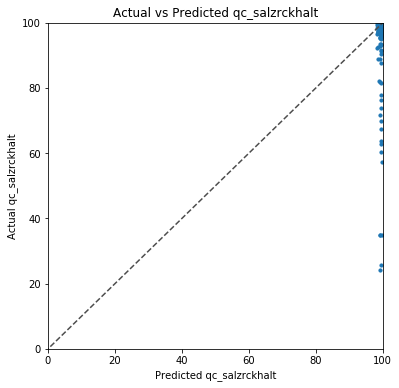

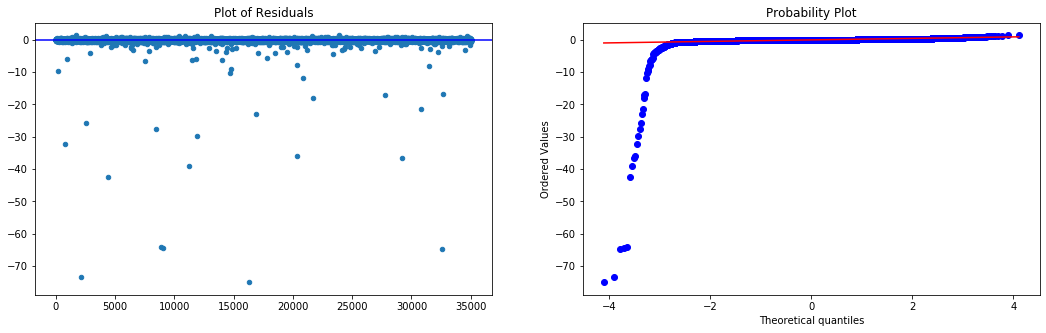

<Figure size 432x288 with 0 Axes>

In [59]:
# import user made function
import linReg
from linReg import LinFunc
LinFunc(X_train,y_train,X_test,y_test,X, y, 'qc_salzrckhalt', 'BayesianRegressor')

RigidRegression Training set score: 0.02


/home/elron/anaconda3/envs/da/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/elron/anaconda3/envs/da/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


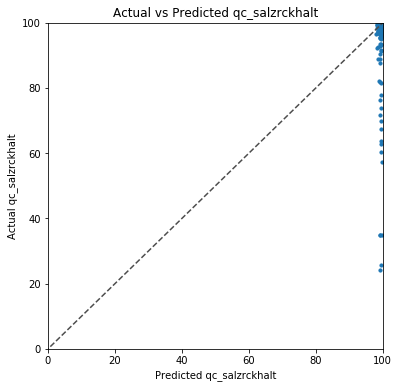

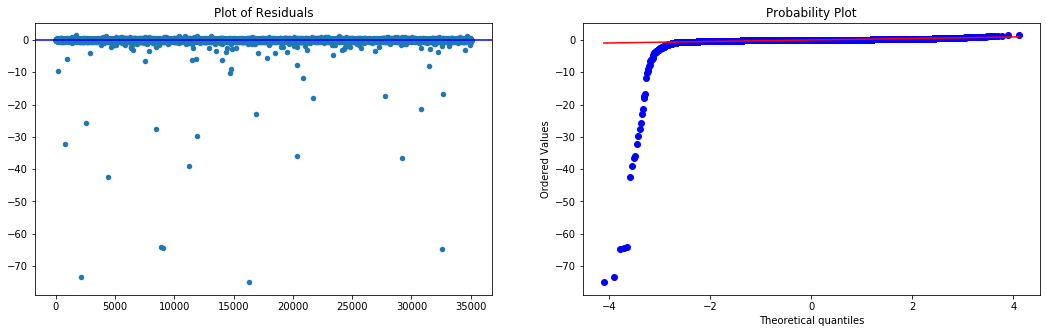

<Figure size 432x288 with 0 Axes>

In [60]:
LinFunc(X_train,y_train,X_test,y_test,X, y, 'qc_salzrckhalt', 'RigidRegression')

In [ ]:
LinFunc(X_train,y_train,X_test,y_test,X, y, 'qc_salzrckhalt', 'SVM')

/home/elron/anaconda3/envs/da/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/elron/anaconda3/envs/da/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


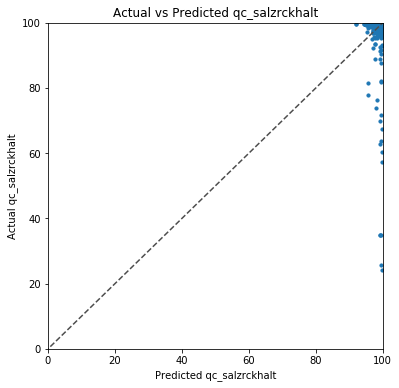

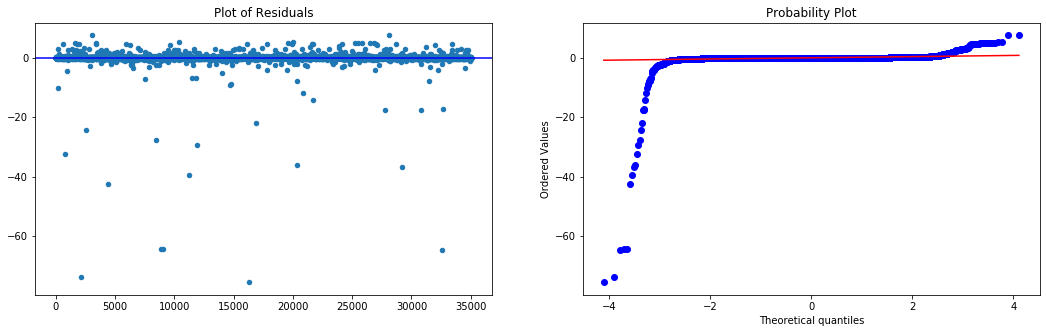

<Figure size 432x288 with 0 Axes>

In [61]:
LinFunc(X_train,y_train,X_test,y_test,X, y, 'qc_salzrckhalt', 'KNeighbors')

DecisionTree Training set score: 0.89


/home/elron/anaconda3/envs/da/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/elron/anaconda3/envs/da/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


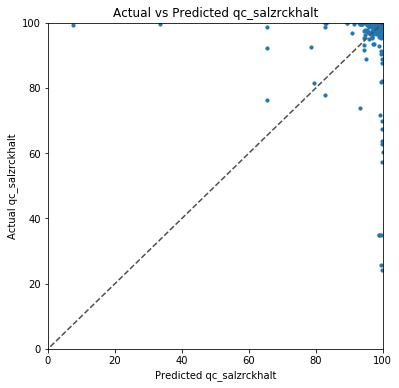

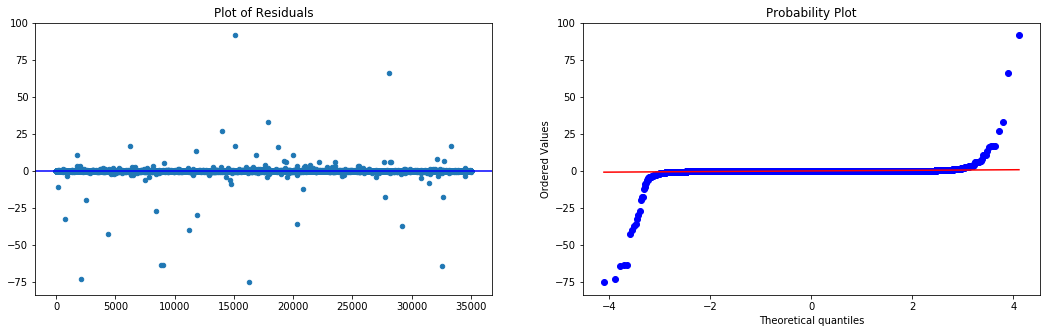

<Figure size 432x288 with 0 Axes>

In [62]:
LinFunc(X_train,y_train,X_test,y_test,X, y, 'qc_salzrckhalt', 'DecisionTree')

 - The residual plot of all models show much room for improvement. Although they are symetrical distributed and  clustered around low y-axis values, there are a significant amount of points who are far away
 
- The models predicitions are not good at all.
 
 
 